# Traffic light concept bottleneck model
Following tutorial at https://pyc-team.github.io/pyc-book/part01_intro/chapter02_cbm.html

In [110]:
# Standard library imports
import random
import pickle

# External imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchview import draw_graph
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
from torch_concepts.data import TrafficLights
from torch_concepts.metrics import intervention_score

# Internal imports
from cbm import CBM

Set seed to ensure same results when notebook rerun

In [111]:
seed = int(42)
torch.manual_seed(42)
np.random.seed(42)

In [112]:
config = {
	"n_epochs": 20,
	"concept_loss_weight": 10,
	"lr": 0.01,
	"batch_size": 50
}

### Import dataset

In [113]:
n_samples = 500
dataset = TrafficLights(
	n_samples=n_samples,
	possible_starting_directions=["west"],
	resize_final_image=0.05,
	seed=0,
	selected_concepts=[
		"green light on selected lane",
		"car in intersection",
		"ambulance seen",
		"ambulance approaching perpendicular to selected car",
	],
	split="train",
)
test_dataset = TrafficLights(
	n_samples=n_samples,
	possible_starting_directions=["west"],
	resize_final_image=0.05,
	seed=0,
	selected_concepts=[
		"green light on selected lane",
		"car in intersection",
		"ambulance seen",
		"ambulance approaching perpendicular to selected car",
	],
	split="test",
)
concept_names, task_names = dataset.concept_names, dataset.task_names
n_concepts = len(concept_names)

# Make a batch dataset loader
data_loader = DataLoader(
	dataset,
	batch_size=config["batch_size"],
	shuffle=True,
	drop_last=False,
	num_workers=2,
)

In [114]:
# Example of scenario
print(f"Input shape: {dataset.input_shape}")
print(f"Using {n_concepts} concepts with semantics: {concept_names}")
print(f"Task has {len(task_names)} downstream tasks: {task_names}")

Input shape: (3, 64, 64)
Using 4 concepts with semantics: [np.str_('green light on selected lane'), np.str_('car in intersection'), np.str_('ambulance seen'), np.str_('ambulance approaching perpendicular to selected car')]
Task has 1 downstream tasks: ['continue']


In [115]:
grid_size = (3, 3)
indices = random.sample(range(len(dataset)), grid_size[0] * grid_size[1])
sampled_images = [dataset[i][0] for i in indices]
sampled_labels = [dataset[i][1] for i in indices]
label_names = ["stop", "continue"]
print(sampled_images[0].shape)

torch.Size([3, 64, 64])


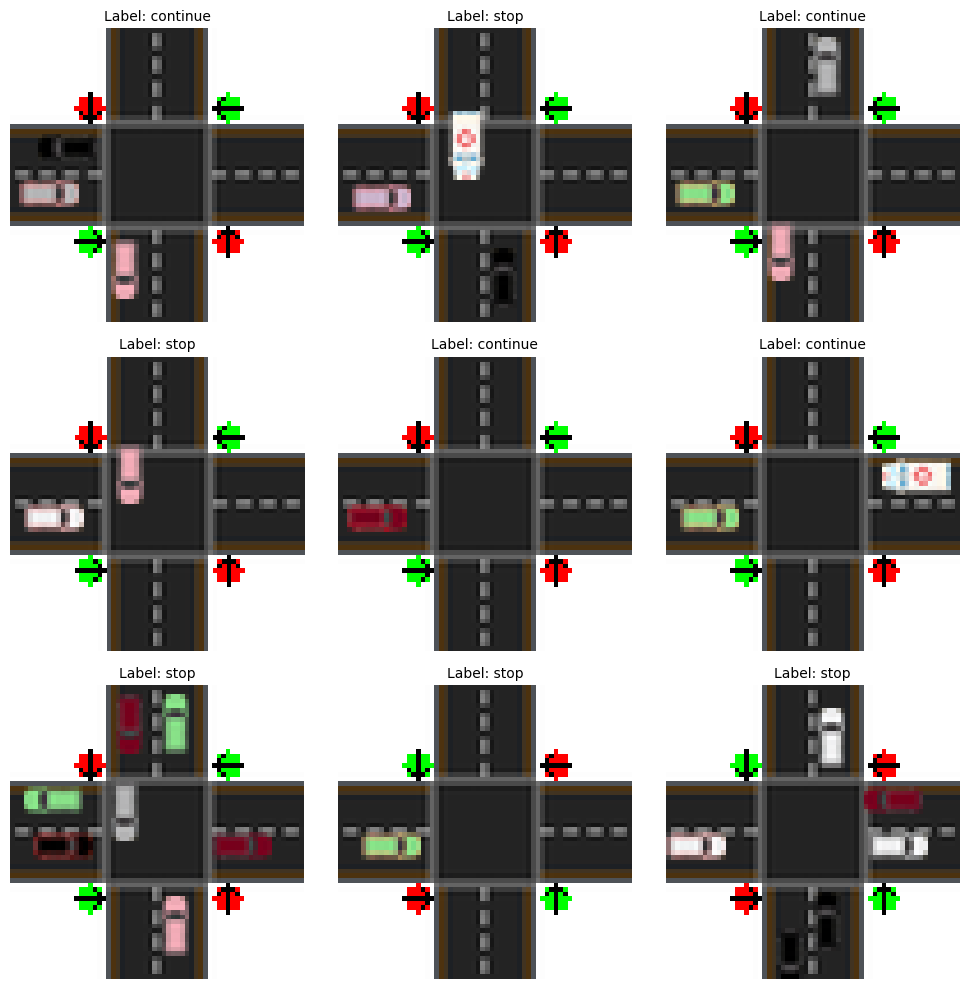

In [116]:
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
axes = axes.flatten()  # Flatten to easily iterate over axes if needed

for i, ax in enumerate(axes):
	ax.imshow(
		sampled_images[i].detach().cpu().numpy().transpose(1, 2, 0),
		cmap=None,
	)
	ax.set_title(
		f"Label: {label_names[int(sampled_labels[i])]}",
		fontsize=10,
	)
	ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

### Define model

In [117]:
latent_dims = 32

In [118]:
model = CBM(n_concepts, latent_dims, concept_names)

In [119]:
# model_graph = draw_graph(model, input_size=(1,3,64,64), expand_nested=True)
# model_graph.visual_graph # TODO: check why this doesn't show predictor

### Train CBM

In [120]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"])
loss_fn = torch.nn.BCELoss()

In [121]:
# with io.capture_output() as captured:
# 	# Standard PyTorch learning cycle
# 	model.train()
# 	for epoch in range(config["n_epochs"]):
# 		for batch_idx, (x, y, c, _, _) in enumerate(data_loader):
# 			# Encode input, then predict concept and downstream tasks activations
# 			out = model(x)
# 			# print(out)
# 			emb = out["enc"]
# 			c_pred = out["lay"]
# 			y_pred = out["pred"]

# 			# Double loss on concepts and tasks
# 			loss = loss_fn(y_pred, y) + config["concept_loss_weight"] * loss_fn(c_pred, c)

# 			# Perform the update
# 			optimizer.zero_grad()
# 			loss.backward()
# 			optimizer.step()
# 			task_acc = torch.mean(((y_pred > 0.5) == y).type(torch.float))
# 			task_acc = task_acc.detach().cpu().numpy()
# 			if ((epoch + 1) % 5 == 0) and (batch_idx == 0):
# 				print(
# 					f"Epoch [{epoch+1}/{config["n_epochs"]}], "
# 					f"Step [{batch_idx+1}/{len(data_loader)}], "
# 					f"Loss: {loss.item():.4f}, "
# 					f"Task Accuracy: {task_acc * 100:.2f}%, "
# 				)

In [122]:
# with open("traffic_light_cbm.pkl", "wb") as f:
#     pickle.dump(model, f)

In [123]:
file_path = "traffic_light_cbm.pkl"
with open(file_path, 'rb') as file:
	model = pickle.load(file)

### Perform intervention

In [124]:
# Load in all samples (as dataset relatively small)
x_samples = []
c_samples = []
y_samples = []
for (x, y, c, _, _) in dataset:
	x_samples.append(x.unsqueeze(0))
	y_samples.append(y.unsqueeze(0))
	c_samples.append(c.unsqueeze(0))
x_samples = torch.concat(x_samples, dim=0)
y_samples = torch.concat(y_samples, dim=0)
c_samples = torch.concat(c_samples, dim=0)

In [125]:
# Filter to training data with green light, no ambulance, and
# no cars in the intersection
samples_with_green_light = (c_samples[:, 0] == 1).detach().cpu().numpy()
samples_with_int_cars = (c_samples[:, 1] == 1).detach().cpu().numpy()
samples_with_ambulance = (c_samples[:, 2] == 1).detach().cpu().numpy()
samples_with_perp_ambulance = (c_samples[:, 3] == 1).detach().cpu().numpy()
selected_samples = (
	samples_with_green_light &
	np.logical_not(samples_with_int_cars) &
	np.logical_not(samples_with_ambulance) &
	np.logical_not(samples_with_perp_ambulance)
)
print(f"Found {np.sum(selected_samples)} samples with green light, no ambulance, and no cars on the intersection")

Found 84 samples with green light, no ambulance, and no cars on the intersection


Get an arbitrary sample

In [126]:
selected_sample = x_samples[selected_samples, :, :, :][0]
selected_label = y_samples[selected_samples][0]

In [127]:
model.eval()
sample = selected_sample.unsqueeze(0)
print(f"Before intervention, model said the car should stop with probability/confidence {model.forward(sample)["pred"].sigmoid().detach()[0]}")

Before intervention, model said the car should stop with probability/confidence 0.7282561659812927


Get the concept predictions for this sample

In [128]:
embedding = model.encoder(sample)
predicted_concepts = model.c_layer(embedding).sigmoid()

Intervene
Set ambulance and ambulance approaching perpendicular to selected car to True

In [129]:
c_intervened = predicted_concepts[0].clone().unsqueeze(0)
c_intervened[0, 2] = 1 # Ambulance
c_intervened[0, 3] = 1 # Ambulance in perpendicular direction 


Generate new prediction based on the modified concepts

In [130]:
y_intervened = model.predictor(c_intervened).sigmoid()

for idx, concept_name in enumerate(concept_names):
	print(
		f"\tThe model predicted that concept '{concept_name}' is {c_intervened[0, idx] > 0.5} "
		f"with probability {c_intervened[0, idx]}.")

	The model predicted that concept 'green light on selected lane' is True with probability 0.9998809099197388.
	The model predicted that concept 'car in intersection' is False with probability 0.00220309104770422.
	The model predicted that concept 'ambulance seen' is True with probability 1.0.
	The model predicted that concept 'ambulance approaching perpendicular to selected car' is True with probability 1.0.


In [131]:
print(f"After intervention, the model now selects that the car should stop with probability {y_intervened.detach()[0][0]}.")

After intervention, the model now selects that the car should stop with probability 0.19615398347377777.


### Evaluate model performance

Load train set

In [132]:
x_train = []
c_train = []
y_train = []
for (x, y, c, _, _) in dataset:
	x_train.append(x.unsqueeze(0))
	y_train.append(y.unsqueeze(0))
	c_train.append(c.unsqueeze(0))
x_train = torch.concat(x_train, dim=0)
y_train = torch.concat(y_train, dim=0)
c_train = torch.concat(c_train, dim=0)

Load the test set

In [133]:
model.eval()
x_test = []
c_test = []
y_test = []
for (x, y, c, _, _) in test_dataset:
	x_test.append(x.unsqueeze(0))
	y_test.append(y.unsqueeze(0))
	c_test.append(c.unsqueeze(0))
x_test = torch.concat(x_test, dim=0)
y_test = torch.concat(y_test, dim=0)
c_test = torch.concat(c_test, dim=0)

##### Task performance

In [134]:
# Pass test data through model
enc, lay, pred = model.forward(x_test).values()

In [135]:
task_performance = roc_auc_score(y_test, pred.sigmoid().detach())
print(f"The model correctly identified the car's desired action with probability {task_performance}.")

The model correctly identified the car's desired action with probability 0.9746889746889746.


##### Concept performance

In [136]:
concept_performance = roc_auc_score(c_test, lay.sigmoid().detach())
print(f"The model correctly identified the car's desired action with probability {concept_performance}.")

The model correctly identified the car's desired action with probability 0.9865888870468612.


### Intervention effectiveness

##### Task performance

In [137]:
c_pred = model.c_layer(model.encoder(x_test)).sigmoid()

In [138]:
# Concepts: 'green light on selected lane', 'car in intersection'
intervention_groups = [[], [0], [1], [0,1]]

intervention_scores = intervention_score(
	model.predictor,
	c_pred,
	c_test,
	y_test,
	intervention_groups,
	auc=False
)

print(f"Individual intervention scores: {[round(i,4) for i in intervention_scores]}")

Individual intervention scores: [0.9747, 0.9592, 0.979, 0.9627]


Intervening on just 'car on intersection' gives best avg performance

In [139]:
intervention_auc = intervention_score(
	model.predictor,
	c_pred,
	c_test,
	y_test,
	intervention_groups
)
print(f"Intervention AUC: {intervention_auc:.4f}")

Intervention AUC: 0.9689


The AUC here is high so that means intervening on concepts improves overall performance

### Concept completeness

In [140]:
model.eval()
y_pred = model.predictor(c_pred).sigmoid()

First, create a black box model equivalent

In [141]:
class ConvLeakyReLu(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same"):
		super(ConvLeakyReLu, self).__init__()
		self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
		self.leaky_relu = nn.LeakyReLU()

	def forward(self, x):
		return self.leaky_relu(self.conv(x))

In [142]:
class BlackBoxModel(nn.Module):
	def __init__(self):
		super().__init__()
		
		self.net = nn.Sequential(
			ConvLeakyReLu(3 + n_concepts, 4),
			ConvLeakyReLu(4, 4),
			torch.nn.BatchNorm2d(4),
			ConvLeakyReLu(4, 4),
			ConvLeakyReLu(4, 4),
			torch.nn.BatchNorm2d(4),
			torch.nn.MaxPool2d((5, 5)),
			torch.nn.Flatten(start_dim=1, end_dim=-1),
			torch.nn.Linear(576, 1),
		)
		
	def forward(self, x):
		return self.net(x)

In [143]:
# Make maps containing the values of each concept
c_train_maps = c_train.unsqueeze(-1).unsqueeze(-1)
c_train_maps = c_train_maps.expand(-1, -1, 64, 64)
c_test_maps = c_test.unsqueeze(-1).unsqueeze(-1)
c_test_maps = c_test_maps.expand(-1, -1, 64, 64)

# Put them together with the input features
xc_train = torch.concat((x_train, c_train_maps), dim=1)
xc_test = torch.concat((x_test, c_test_maps), dim=1)

# Defining a black box baseline
baseline = BlackBoxModel()

# Define optimizer and loss function
optimizer = torch.optim.AdamW(baseline.parameters(), lr=config["lr"])
loss_fn = torch.nn.BCELoss()

# Train model
baseline.train()
for epoch in range(config["n_epochs"]):
   optimizer.zero_grad()

   # Encode input, then predict concept and downstream tasks activations
   y_pred_baseline = baseline(xc_train).sigmoid().view(-1)

   # Double loss on concepts and tasks
   loss = loss_fn(y_pred_baseline, y_train)
   loss.backward()
   optimizer.step()

baseline.eval()
y_pred_baseline = baseline(xc_test).sigmoid()
task_performance_baseline = roc_auc_score(y_test, y_pred_baseline.detach())

In [144]:
from torch_concepts.metrics import completeness_score

concept_completeness = completeness_score(y_test, y_pred_baseline, y_pred)

print(f'Task performance: {task_performance*100:.2f}%')
print(f'Task performance baseline: {task_performance_baseline*100:.2f}%')
print(f'Concept completeness: {concept_completeness*100:.2f}%')

Task performance: 97.47%
Task performance baseline: 97.77%
Concept completeness: 99.69%
